In [1]:
import json
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import warnings
import torch
import torchinfo

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
from tqdm import tqdm

from local_python.feature_evaluation import calculate_scores
from local_python.general_utils import (
    load_model,
    load_values_from_previous_epochs,
    set_seed,
    print_parameters,
)
from local_python.dataset_util import (
    create_dataloaders,
)
from ssl_library.src.models.fine_tuning.classifiers import LinearClassifier

In [7]:
max_iter = 10_000
seed = 1
number_of_samples = 100

# Train logistic regression
dataset_path_features = (
    # "../datasets/intermediate-features/HAM10000-ViT_T16-Derma.csv",
    # "../datasets/intermediate-features/HAM10000-ViT_T16-Plant.csv",
    "../datasets/intermediate-features/HAM10000-ViT_T16-ImageNet_1k_SSL_Dino.csv",
)[0]

run_path = (
    # f"../runs/HAM10000/ViT_T16-Derma/logreg_0_{seed}_{number_of_samples}",
    # f"../runs/HAM10000/ViT_T16-Plant/logreg_0_{seed}_{number_of_samples}",
    f"../runs/HAM10000/ViT_T16-ImageNet_1k_SSL_Dino/logreg_0_{seed}_{number_of_samples}",
)[0]


# Validate with ViT
batch_size = 64
dataset_path_images = "../data_splits/HAM10000_split.csv"
checkpoint_path = (
    # "../model_weights/vit_t16_v2/ViT_T16-Derma_SSL_Dino_headless.pth",
    # "../model_weights/vit_t16_v2/ViT_T16-Plant_SSL_Dino_headless.pth",
    "../model_weights/vit_t16_v2/ViT_T16-ImageNet_1k_SSL_Dino_headless.pth",
)[0]

In [8]:
set_seed(seed)
selection_seed = seed

Setting seed to 1


In [9]:
if not os.path.exists(run_path):
    os.makedirs(run_path)

df_full = pd.read_csv(dataset_path_features, index_col=0)
label_map = {
    label: idx for idx, label in enumerate(df_full["target_code"].unique())
}  # NOTE: Keep original order

(loss_file_path, latest_epoch, best_loss) = load_values_from_previous_epochs(run_path)

features = {}
targets = {}
for set_name in df_full["set"].unique():
    df_set = df_full[df_full["set"] == set_name]
    if (number_of_samples is not None) and (set_name == "train"):
        target_group = df_full.groupby("target_code")
        df_set = target_group.sample(
            number_of_samples, random_state=selection_seed, replace=False
        )

    print(f"{set_name} size: {len(df_set)}")
    features[set_name] = df_set.loc[:, ~df_set.columns.isin(["target_code", "set"])]
    targets[set_name] = df_set["target_code"].to_numpy()

train size: 700
valid size: 1103
test size: 1511


In [11]:
def calculate_metrics(set_name, i, detaillog):
    loss = log_loss(targets[set_name], model_lr.predict_proba(features[set_name]))
    pred = model_lr.predict(features[set_name])
    line = {}
    line["epoch"] = i
    line["loss"] = loss
    line["set"] = set_name
    line = calculate_scores(
        targets[set_name],
        pred,
        line,
    )
    json.dump(line, detaillog, indent=2)
    return loss

In [12]:
def print_confusion_matrix(set_name):
    preds = model_lr.predict(features[set_name])
    metrics = calculate_scores(
        targets[set_name],
        preds,
        {},
    )
    print(metrics)
    cm = confusion_matrix(
        [label_map[target] for target in targets[set_name]],
        [label_map[pred] for pred in preds],
    )
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_map.keys()
    )
    cm_display.plot()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


In [13]:
model_lr = LogisticRegression(max_iter=1, warm_start=True, random_state=seed)
print(model_lr.get_params(deep=True))  # NOTE: No class weights

with open(loss_file_path, "a") as detaillog:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)

        for i in tqdm(range(max_iter)):
            model_lr.fit(features["train"], targets["train"])
            calculate_metrics("train", i, detaillog)

            valid_loss = calculate_metrics("valid", i, detaillog)
            if best_loss is None or valid_loss < best_loss:
                best_loss = valid_loss
                np.save(os.path.join(run_path, f"weights.npy"), model_lr.coef_)
                np.save(os.path.join(run_path, f"biases.npy"), model_lr.intercept_)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 1, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': True}


100%|██████████| 10000/10000 [14:13<00:00, 11.71it/s]


{'accuracy': 1.0, 'balanced_accuracy': 1.0, 'f1_weighted': 1.0, 'f1_micro': 1.0, 'f1_macro': 1.0}


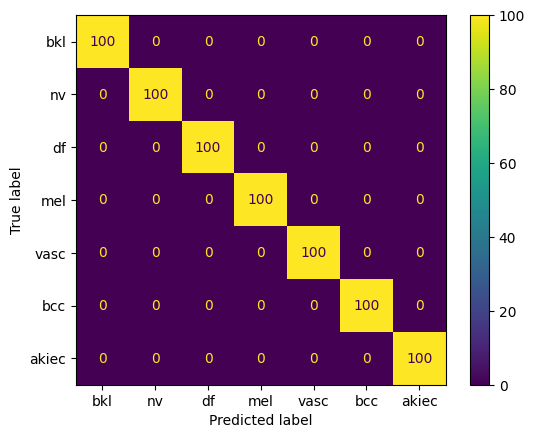

In [14]:
print_confusion_matrix("train")

{'accuracy': 0.6881233000906618, 'balanced_accuracy': 0.7349137285056985, 'f1_weighted': 0.7141345653461184, 'f1_micro': 0.6881233000906618, 'f1_macro': 0.5616896992383494}


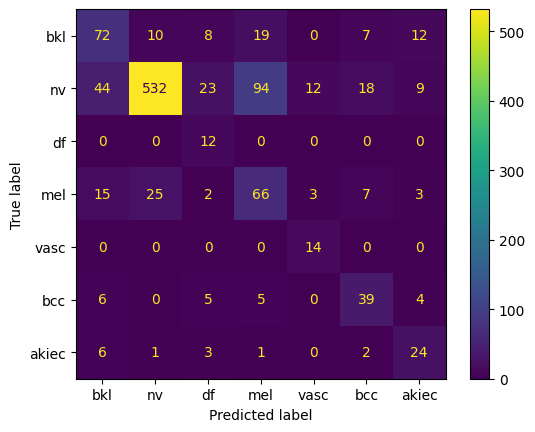

In [15]:
print_confusion_matrix("valid")

{'accuracy': 0.6604897418927862, 'balanced_accuracy': 0.7021691705810704, 'f1_weighted': 0.6848199229135226, 'f1_micro': 0.6604897418927862, 'f1_macro': 0.5809222741208883}


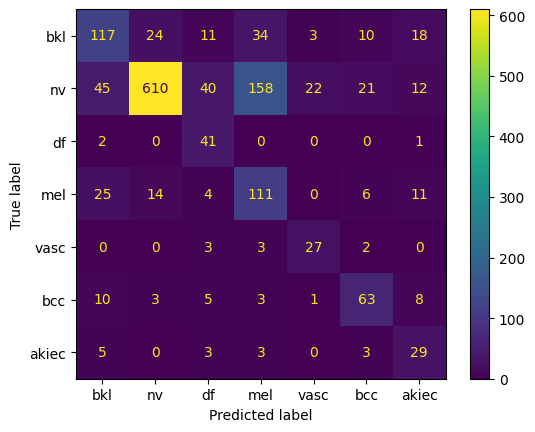

In [16]:
print_confusion_matrix("test")

In [17]:
def eval(model, data_loader_valid, sample=False, verbose=False):
    model = model.to(device)
    model.eval()

    label_tensor = torch.zeros(0)
    pred_tensor = torch.zeros(0)

    with torch.no_grad():
        for images, targets in tqdm(data_loader_valid):
            label_tensor = torch.cat([label_tensor, targets])
            images = images.to(device)
            targets = torch.as_tensor(targets).to(device)

            outputs = model(images)
            # loss = criterion(outputs, targets)

            _, preds = torch.max(outputs, 1)
            pred_tensor = torch.cat([pred_tensor, preds.view(-1).cpu()])
            if verbose:
                for output, target in zip(outputs, targets):
                    probs = softmax(output.cpu().detach().numpy())
                    max_idx = np.argmax(probs)
                    print(
                        f"Actual class {label_map[target]}, predicted class {max_idx} with probability {probs[max_idx]} "
                    )
            if sample:
                break
    return label_tensor.numpy(), pred_tensor.numpy()

In [18]:
np_weights = np.load(os.path.join(run_path, f"weights.npy"))
np_biases = np.load(os.path.join(run_path, f"biases.npy"))
weights_shape = np_weights.shape
biases_shape = np_biases.shape
print(f"Loaded weights {weights_shape} and biases {biases_shape}")

Loaded weights (7, 768) and biases (7,)


In [19]:
assert torch.cuda.is_available()
n_devices = torch.cuda.device_count()
for i in range(0, n_devices):
    print(torch.cuda.get_device_name(i))

device = torch.device("cuda")

NVIDIA GeForce GTX 960


In [20]:
dataloaders = create_dataloaders(dataset_path_images, batch_size=batch_size)
images, _ = next(iter(dataloaders["valid"]))
image_shape = images.shape[1:]

Set train size: 8908
Set valid size: 1103


In [21]:
model = load_model(checkpoint_path, freeze=True, use_ssl_library=True)
summary = torchinfo.summary(model, image_shape, batch_dim=0)
last_output = summary.summary_list[-1].output_size[-1]
model.head = LinearClassifier(
    last_output,
    num_labels=len(label_map),
    use_dropout_in_head=True,
    large_head=False,
    use_bn=True,
)
print_parameters(model)

Loading vit_tiny_patch16_224 from timm-library
Trainable parameters: 6919/5531335


In [22]:
assert model.head.linear.weight.shape == weights_shape
assert model.head.linear.bias.shape == biases_shape
model.head.linear.weight.data = torch.tensor(np_weights).float()
model.head.linear.bias.data = torch.tensor(np_biases).float()

In [23]:
labels, preds = eval(model, dataloaders["valid"])

100%|██████████| 18/18 [00:13<00:00,  1.36it/s]


In [24]:
rearrange_dict = {0: 6, 1: 5, 2: 0, 3: 2, 4: 3, 5: 1, 6: 4}
rearranged_preds = [rearrange_dict[pred] for pred in preds]

In [25]:
metrics = calculate_scores(
    labels,
    rearranged_preds,
    {},
)
print(metrics)

{'accuracy': 0.7334542157751587, 'balanced_accuracy': 0.7144018324096754, 'f1_weighted': 0.7518717872939173, 'f1_micro': 0.7334542157751587, 'f1_macro': 0.5760895337867729}


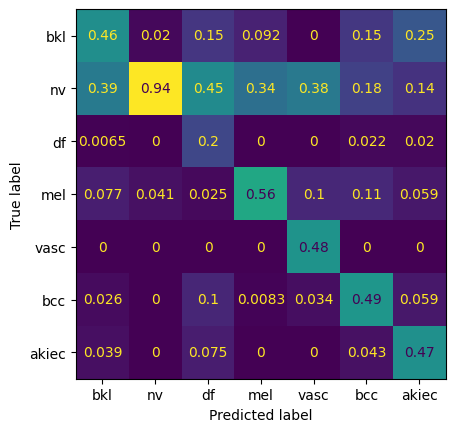

In [26]:
label_names = [
    k for k, v in label_map.items() if (v in labels or v in rearranged_preds)
]
cm = confusion_matrix(labels, rearranged_preds, normalize='pred')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
cm_display.plot(colorbar=False, values_format=".2g")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.savefig(os.path.join(run_path, f"confusion_matrix_valid.png"), bbox_inches="tight")
plt.show()